__Imports__

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt

__Read in Data__

In [2]:
df = pd.read_csv("final_data_file_with_encoding.csv")
df.head()

,id,anchor,target,context,score,anchor_len,target_len,section,classes,context_desc,...,spacy_total,spacy_avg_at,spacy_avg_c,fuzzy_at_score,fuzzy_ac_score,fuzzy_tc_score,fuzzy_c_score,fuzzy_total,fuzzy_avg_at,fuzzy_avg_c
0,37d61fd2272659b1,44,46,A47,0.50,1,2,36,47,10103,...,0.000000,NaN,NaN,53,6,13,19,72,0.736111,0.263889
1,7b9652b17b68b7a4,44,257,A47,0.75,1,2,36,47,10103,...,0.388094,0.0,1.0,67,6,8,14,81,0.827160,0.172840
2,36d72442aefd8232,44,276,A47,0.25,1,2,36,47,10103,...,0.085102,0.0,1.0,33,6,16,22,55,0.600000,0.400000
3,5296b0c19e1ce60e,44,8048,A47,0.50,1,2,36,47,10103,...,0.427271,0.0,1.0,0,6,14,20,20,0.000000,1.000000
4,54c1e3b9184cb5b6,44,9734,A47,0.00,1,2,36,47,10103,...,0.415349,0.0,1.0,12,6,20,26,38,0.315789,0.684211


__Fill in Null values__

In [3]:
df.fillna(0,inplace=True)

__Correlation Check Among features only__

In [4]:
features = df.drop('score',axis=1)
# Create correlation matrix
corr_matrix = features.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features 
features.drop(to_drop, axis=1, inplace=True)

/var/folders/13/5qrysg6938s14gxnpjdn6b540000gn/T/ipykernel_12737/3226852571.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [5]:
df_2 = features
df_2['score'] = df['score']

<AxesSubplot:>

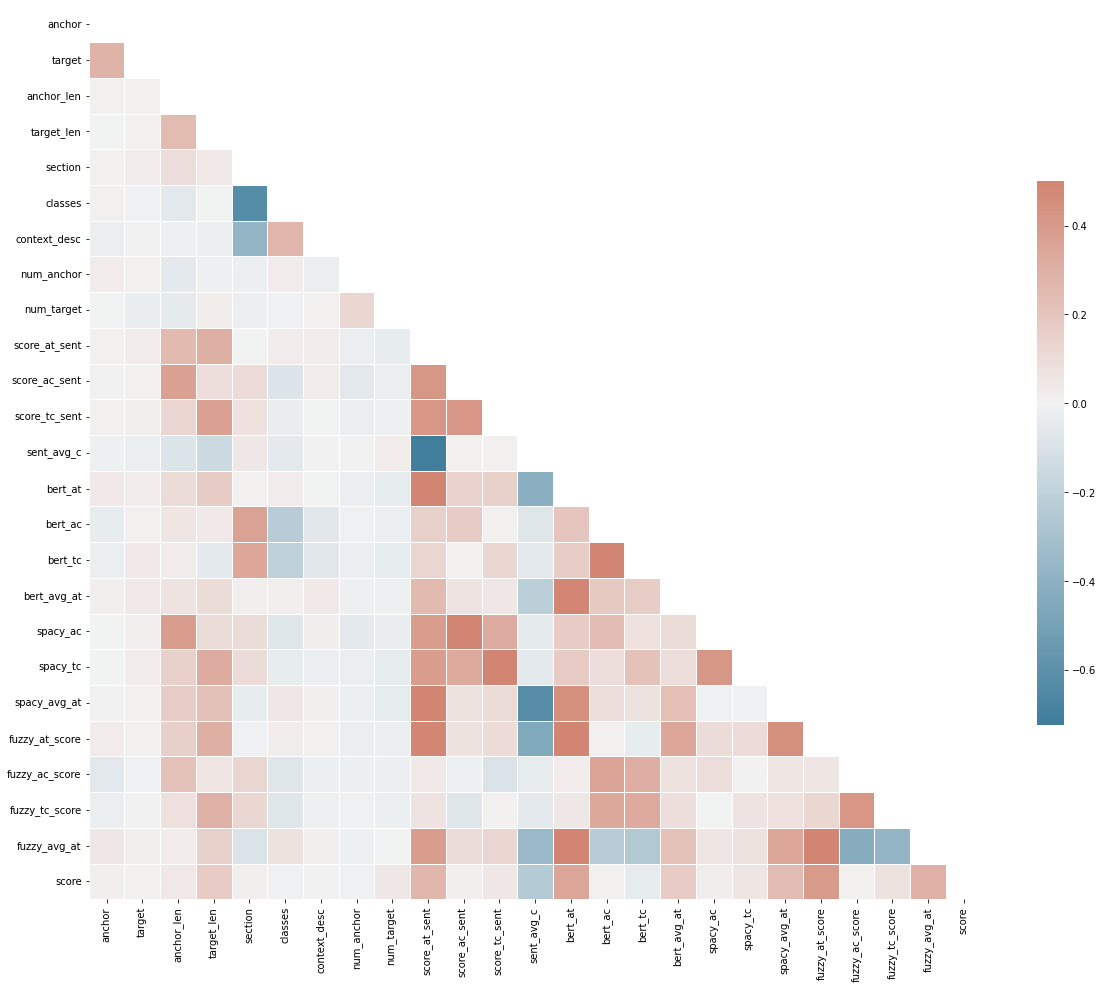

In [6]:
correlation_matrix = df_2.corr(method='spearman')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.5, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


__Get the features that have a positive correlation with score__

In [7]:
indecies_pos = np.where(correlation_matrix['score'] > 0)
improved_features_pos = correlation_matrix.iloc[indecies_pos].drop('score')
improved_features_pos['score']

anchor            0.012513
target            0.005400
anchor_len        0.043443
target_len        0.179157
section           0.012529
num_target        0.047326
score_at_sent     0.267441
score_ac_sent     0.012725
score_tc_sent     0.046938
bert_at           0.353972
bert_ac           0.008446
bert_avg_at       0.177569
spacy_ac          0.017530
spacy_tc          0.054077
spacy_avg_at      0.246161
fuzzy_at_score    0.403842
fuzzy_ac_score    0.010377
fuzzy_tc_score    0.069892
fuzzy_avg_at      0.294686
Name: score, dtype: float64

__Features to be used in model__

In [8]:
feats = list(improved_features_pos.index)

### Model Evaluation

In [9]:
x = df[feats].values
y = df['score'].values

__Random Forest__

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True,random_state=141)
kf.get_n_splits(x)
print(kf)
mse_arr = []
mape_arr = []
rmse_arr = []
mae_arr = []
for train_index, test_index in kf.split(x):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    from sklearn.ensemble import RandomForestRegressor
    clf = RandomForestRegressor(random_state=141,n_estimators = 1000,
                                min_samples_split= 10,
                                min_samples_leaf= 2,
                                max_features= 'sqrt',
                                max_depth= 10,
                                bootstrap= True)
    clf.fit(x_train,y_train)
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    y_pred = clf.predict(x_test)
    #y_pred = [x_round(i) for i in y_pred]
    mse = mean_squared_error(y_test, y_pred)
    mape = r2_score(y_test,y_pred)
    rmse = mean_squared_error(y_test, y_pred,squared=False)
    mae = mean_absolute_error(y_test,y_pred)
    print("Mean Square Error: {} \nRoot Mean Squared Error: {} \nMean Absolute Error: {} \nR-Squared: {} ".format(mse,rmse,mae,mape))
    mse_arr.append(mse)
    mape_arr.append(mape)
    rmse_arr.append(rmse)
    mae_arr.append(mae)




KFold(n_splits=5, random_state=141, shuffle=True)
TRAIN: [    0     2     3 ... 36470 36471 36472] TEST: [    1     4     9 ... 36449 36453 36457]
Mean Square Error: 0.04332968134597487 
Root Mean Squared Error: 0.2081578279718898 
Mean Absolute Error: 0.15871597383981748 
R-Squared: 0.3469226373696688 
TRAIN: [    1     2     3 ... 36470 36471 36472] TEST: [    0     6    10 ... 36455 36456 36467]
Mean Square Error: 0.0434745273703186 
Root Mean Squared Error: 0.20850546124818553 
Mean Absolute Error: 0.15964243865029965 
R-Squared: 0.35877208883904155 
TRAIN: [    0     1     2 ... 36468 36471 36472] TEST: [    5    12    23 ... 36464 36469 36470]
Mean Square Error: 0.04374850360668626 
Root Mean Squared Error: 0.20916142953873273 
Mean Absolute Error: 0.16070461523204702 
R-Squared: 0.33720499704293905 
TRAIN: [    0     1     3 ... 36469 36470 36472] TEST: [    2     7     8 ... 36465 36466 36471]
Mean Square Error: 0.04400460535992982 
Root Mean Squared Error: 0.20977274694280432 

In [ ]:
print("Mean Square Error: {} \nRoot Mean Squared Error: {} \nMean Absolute Error: {} \nR-Squared: {} ".format(np.mean(mse_arr),np.mean(rmse_arr),np.mean(mae_arr), np.mean(mape_arr)))
                                                           

In [ ]:
import shap
shap_values = shap.TreeExplainer(clf).shap_values(x_train[:100])
shap.summary_plot(shap_values, x_train[:100], plot_type="bar",feature_names=feats)

In [ ]:
shap.summary_plot(shap_values, x_train[:100],feature_names=feats)

In [ ]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(clf.estimators_[1], out_file='tree.dot', 
                feature_names = feats,
                max_depth = 3,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

__CatBoostRegressor__

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True,random_state=141)
kf.get_n_splits(x)
print(kf)
mse_arr = []
mape_arr = []
rmse_arr = []
mae_arr = []
for train_index, test_index in kf.split(x):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    from catboost import CatBoostRegressor
    cat_base = CatBoostRegressor(
        eval_metric='MAE'
    )
    cbf = cat_base.fit(x_train, y_train, silent=True)
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
    y_pred = cbf.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    mape = r2_score(y_test,y_pred)
    rmse = mean_squared_error(y_test, y_pred,squared=False)
    mae = mean_absolute_error(y_test,y_pred)
    mse_arr.append(mse)
    mape_arr.append(mape)
    rmse_arr.append(rmse)
    mae_arr.append(mae)
    print("Mean Square Error: {} \nRoot Mean Squared Error: {} \nMean Absolute Error: {} \nR-Squared: {} ".format(mse,rmse,mae,mape))

In [ ]:
print("Mean Square Error: {} \nRoot Mean Squared Error: {} \nMean Absolute Error: {} \nR-Squared: {} ".format(np.mean(mse_arr),np.mean(rmse_arr),np.mean(mae_arr), np.mean(mape_arr)))
                                                           

In [ ]:
import shap
shap_values = shap.TreeExplainer(cbf).shap_values(x_train[:100])
shap.summary_plot(shap_values, x_train[:100], plot_type="bar",feature_names=feats)

In [ ]:
shap.summary_plot(shap_values, x_train[:100],feature_names=feats)

In [ ]:
from xgboost import plot_tree

In [ ]:
import matplotlib.pyplot as plt
import catboost
from catboost import CatBoostRegressor, Pool
pool = Pool(x_train, y_train,feature_names=feats)

In [ ]:
cbf.plot_tree(tree_idx=0,pool=pool)